# Titanic Dataset

Titanic dataset fetched from kaggle: https://www.kaggle.com/c/titanic

The goal is to correctly predict if a passenger survived the titain shipwreck.

Below is a walkthrough of imploying EDA and scikit-learn classification algorithms to predict results.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [24]:
train = pd.read_csv("data/train.csv")
test =  pd.read_csv("data/test.csv")

# Data Overview

In [25]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [27]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [28]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Summary: 

1. Missing values: Age(177), Cabin(687), Embarked(2)
2. Numerical vars: Age,SibSp, Parch, Fare
3. Categorical vars: Sex, Embarked, Pclass

# Exploratory Data Analysis

Split columns into numerical and categorical types and visualize data to search for meaningful relationships

## Numerical Anaylsis

In [29]:
col_num = ['Age','SibSp', 'Parch', 'Fare']

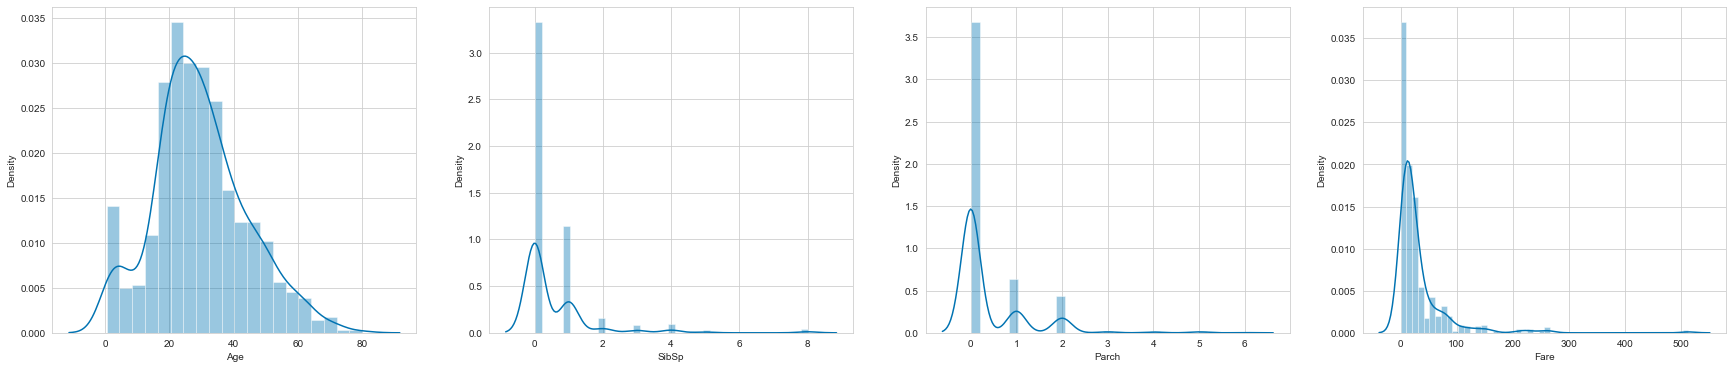

In [30]:
sns.set_palette("colorblind")
fig, ax = plt.subplots(1,4, figsize=(30,6))
for idx,col in enumerate(col_num):
    sns.distplot(train[col], ax=ax[idx])

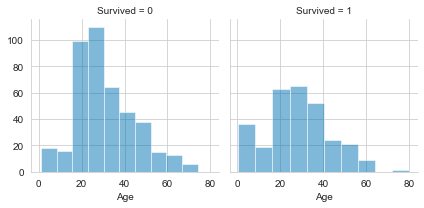

In [31]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', alpha=0.5)

In [32]:
pd.pivot_table(train, index='Survived', values=col_num)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

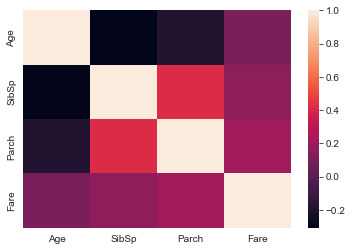

In [33]:
print(train[col_num].corr())
sns.heatmap(train[col_num].corr())

### Summary: 

1. Age is normally distributed
2. Right skew found in taking "Age" dependent on "Survived" : more younger people died
3. Fare is right skewed and needs to be normalized
4. Mean average of fare paid is higher for passengers who survived then those who died

## Categorical Analysis

In [34]:
col_cat = ['Sex', 'Embarked','Pclass']

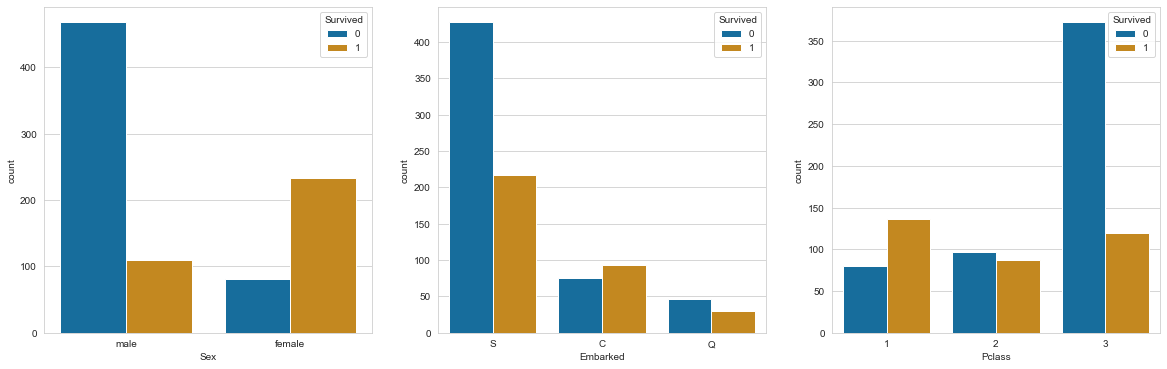

In [35]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,len(col_cat), figsize=(20,6))
for idx, col in enumerate(col_cat):
    sns.countplot(x=col, data=train, ax=ax[idx], hue="Survived")

plt.show()

### Summary: 

1. More males died then females
2. Pclass looks ordinal: 1 < 2 < 3 $\rightarrow$  coach < business < first

## Feature Engineering

From above EDA, use features for modeling [Sex, Pclass, Age, Fare]. However need to perform the following prior modeling

1. Normalize Fare to avoid overfitting
2. Impute Age NAs with the median age of associated class and gender
3. Normalize Age to avoid overfitting


### 1. Normalize Fare

In [36]:
#print(train["Fare"].describe())
coach = train[train["Fare"] < 12]
business = train[(train["Fare"] >= 12) & (train["Fare"] < 30)]
first = train[(train["Fare"] >= 30)]

def adjust_price(x):
    if x < 12: 
        return 0
    elif  30 > x >= 12:
        return 1
    elif  x >= 30:
        return 2

train["Fare"] = train["Fare"].apply(adjust_price)
test["Fare"] = train["Fare"].apply(adjust_price)

print("Coach: {0}, Business: {1}, First: {2}".format(len(coach), len(business), len(first) ))

Coach: 373, Business: 278, First: 240


<AxesSubplot:xlabel='Fare', ylabel='count'>

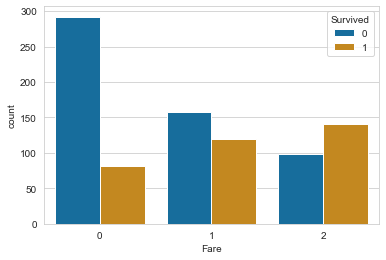

In [37]:
sns.countplot(x="Fare", data=train, hue="Survived")

### 2. Impute Age NAs

In [38]:
for x in [1,2,3]:
    for y in ["male", "female"]:
        # Train 
        mean_age = train[~pd.isnull(train["Age"]) & (train["Sex"] == y) & (train["Pclass"] == x)].Age.median()
        train.loc[pd.isnull(train["Age"]) & (train["Sex"] == y) & (train["Pclass"] == x), "Age"] = mean_age 
        
        # Test
        mean_age = test[ ~pd.isnull(test["Age"]) & (test["Sex"] == y) & (test["Pclass"] == x)].Age.median()
        test.loc[pd.isnull(test["Age"]) & (test["Sex"] == y) & (test["Pclass"] == x), "Age"] = mean_age

### 3. Normalize Age

In [39]:
def adjust_age(x):
    if x < 16: 
        return 0
    elif  30 > x >= 16:
        return 1
    elif 40 > x >= 30:
        return 2
    elif x >= 40:
        return 3
        
train["Age"] = train["Age"].apply(adjust_age)
test["Age"] = test["Age"].apply(adjust_age)

## Prepare Model  

In [40]:
train["Sex"] = train["Sex"].map({"female":0, "male":1})
test["Sex"] = test["Sex"].map({"female":0, "male":1})

In [41]:
features_col = ["Sex","Pclass", "Age", "Fare"]
target_col = ["Survived"]

X_train = train[features_col]
X_test = test[features_col]
y_train = train[target_col]

# Classification Models

Note: Scored on training data for example purposes, can only score on test data in Kaggle

## K Nearest Neighbor

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

score = round(knn.score(X_train, y_train) * 100, 2)
score

82.83

## Logistic Regression 

In [43]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 2000)
lr.fit(X_train, y_train)
score = round(lr.score(X_train, y_train) * 100, 2)
score

79.91